In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle  # To save datasets and scalerse
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, nhead, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim,dim_feedforward=32,nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, src):
        src = self.input_embedding(src) * math.sqrt(self.hidden_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.output_layer(output[:, -1, :])
        return output



def create_datasets(X, y, batch_size=256):
    dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [3]:
def train_model(model, train_loader, val_loader, device, num_epochs=2):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()  # Switch to evaluation mode for validation
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss = criterion(outputs.squeeze(), y_batch)
                val_losses.append(val_loss.item())

        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}')

    return model, history


In [3]:
# def create_multivariate_dataset(data, time_step):
#     X, Y = [], []
#     for i in range(len(data) - time_step):
#         X.append(data[i:(i + time_step), :])
#         Y.append(data[i + time_step, 0])
#     return np.array(X), np.array(Y)



import numpy as np

def create_multivariate_dataset(data, time_step):
    X, Y = [], []
    # Loop goes up to the last element, as now we want to include the current day's features in X
    for i in range(len(data) - time_step - 1):  # Adjust to ensure space for the last Y element
        # Include the current day's features by extending the slice up to i + time_step + 1
        X.append(data[i:(i + time_step + 1), :])  # X includes data up to and including the current day
        Y.append(data[i + time_step + 1, 0])      # Y is still the next day's target feature
    return np.array(X), np.array(Y)


In [4]:
def process_and_save_data(data_path, feature_list, output_path, time_step=365, train_split=0.67):
    data = pd.read_csv(data_path, index_col='Date', parse_dates=True, low_memory=False)
    selected_features = ['StationID'] + feature_list
    data = data[selected_features]

    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    X_train_all, y_train_all, X_test_all, y_test_all = [], [], [], []

    for station_id in data['StationID'].unique():
        station_data = data[data['StationID'] == station_id].drop(columns=['StationID'])
        station_data.replace('Min', np.nan, inplace=True)
        station_data = station_data.dropna().ffill()

        # Initialize a new scaler for each station
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(station_data)
        X, y = create_multivariate_dataset(scaled_data, time_step)

        train_size = int(len(X) * train_split)
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        X_train_all.append(X_train)
        y_train_all.append(y_train)
        X_test_all.append(X_test)
        y_test_all.append(y_test)

        # Save train and test sets along with the scaler for each station
        with open(os.path.join(output_path, f'station_{station_id}_train.pkl'), 'wb') as f:
            pickle.dump((X_train, y_train), f)
        with open(os.path.join(output_path, f'station_{station_id}_test.pkl'), 'wb') as f:
            pickle.dump((X_test, y_test), f)
        with open(os.path.join(output_path, f'station_{station_id}_scaler.pkl'), 'wb') as f:
            pickle.dump(scaler, f)  # Save the scaler object

    return np.concatenate(X_train_all, axis=0), np.concatenate(y_train_all, axis=0), \
           np.concatenate(X_test_all, axis=0), np.concatenate(y_test_all, axis=0)


def train_and_evaluate_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim=32, num_layers=11, output_dim=1, num_epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, nhead=4, dropout=0.1)
    model.to(device)
    train_loader = create_datasets(X_train, y_train)
    val_loader = create_datasets(X_test, y_test)

    trained_model, history = train_model(model, train_loader, val_loader, device, num_epochs=num_epochs)

    return trained_model, history


def save_and_plot_results(model, history, model_path, plot_path):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_path + "_loss_plot.png")
    plt.close()

    torch.save(model.state_dict(), model_path + "_model.pth")


In [5]:
# Set up paths and features
data_path = '/home/agupt344/Final project/combined_stations_data.csv'
model_base_path = '/home/agupt344/Final project/transformer_model'
plot_base_path = '/home/agupt344/Final project/trnsformer_loss_plot'
output_path = '/home/agupt344/Final project/processed_data'

feature_list = ['Streamflow', 'Area', 'Aspect', 'combined_precipitation_TRMM_sum_1', 'combined_precipitation_TRMM_avg_1', 'combined_precipitation_CHIRPS_sum', 'combined_temperature',
               'combined_precipitation_PERSIANN', 'combined_surface_pressure', 'combined_total_precipitation_Era5_sum', 'combined_precipitation_CHIRPS', 'combined_NDSI_Snow_Cover_Terra',
               'combined_precipitation_PERSIANN_sum', 'combined_total_precipitation']


# Ensure the directories exist
os.makedirs(os.path.dirname(model_base_path), exist_ok=True)
os.makedirs(os.path.dirname(plot_base_path), exist_ok=True)
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Process data
X_train, y_train, X_test, y_test = process_and_save_data(data_path, feature_list, output_path)




In [ ]:
# Train and evaluate the model
trained_model, history = train_and_evaluate_model(X_train, y_train, X_test, y_test, input_dim=X_train.shape[2])

# Save the model and plot results
save_and_plot_results(trained_model, history, model_base_path, plot_base_path)

Epoch 1/30, Train Loss: 0.0153, Val Loss: 0.0035
Epoch 2/30, Train Loss: 0.0030, Val Loss: 0.0020
Epoch 3/30, Train Loss: 0.0021, Val Loss: 0.0023
Epoch 4/30, Train Loss: 0.0018, Val Loss: 0.0022
Epoch 5/30, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 6/30, Train Loss: 0.0016, Val Loss: 0.0019
Epoch 7/30, Train Loss: 0.0014, Val Loss: 0.0014
Epoch 8/30, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 9/30, Train Loss: 0.0014, Val Loss: 0.0018
Epoch 10/30, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 11/30, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 12/30, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 13/30, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 14/30, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 15/30, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 16/30, Train Loss: 0.0012, Val Loss: 0.0012


In [6]:
len(X_train)

101552

## Lets evaluate the model

In [7]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_path = '/home/agupt344/Final project/transformer_model_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_model = TransformerModel(input_dim=14, hidden_dim=32, num_layers=11, output_dim=1, nhead=4, dropout=0.1)




In [8]:
sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

71617

In [9]:
transformer_model.load_state_dict(torch.load(model_path))
#transformer_model.to(device)
transformer_model.eval()

TransformerModel(
  (input_embedding): Linear(in_features=14, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-10): 11 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [10]:
sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

71617

In [11]:
import pickle
import os

def load_data_from_pickle(output_path):
    test_data = {}
    files = [f for f in os.listdir(output_path) if f.endswith('_test.pkl')]
    for file in files:
        station_id = file.split('_')[1]  # file name format 'station_{ID}_test.pkl'
        with open(os.path.join(output_path, file), 'rb') as f:
            X_test, y_test = pickle.load(f)
        test_data[station_id] = (X_test, y_test)
    return test_data

test_data = load_data_from_pickle('/home/agupt344/Final project/processed_data')


In [12]:
from tqdm import tqdm
def predict_data(model, test_data):
    predictions = {}
    for station_id, (X_test, y_test) in tqdm(test_data.items()):
        X_tensor = torch.tensor(X_test).float()
        #X_tensor = X_tensor.to(device)
        pred = model (X_tensor).detach().numpy()
        predictions[station_id] = (pred, y_test)
    return predictions

predictions = predict_data(transformer_model, test_data)


100%|██████████| 31/31 [04:04<00:00,  7.87s/it]


In [ ]:
transformer_model = transformer_model.to(device)
transformer_model.eval()  # Set the model to evaluation mode
test_loss_accum = 0
num_batches = 0
# Ensure the input data is also moved to the same device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Example of data loader setup
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
criterion = nn.MSELoss()

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = transformer_model(inputs)
        test_loss = criterion(outputs.squeeze(), targets.squeeze())  # Make sure dimensions match
        test_loss_accum += test_loss.item()
        num_batches += 1

average_test_loss = test_loss_accum / num_batches
print(f'Average Test Loss: {average_test_loss:.4f}')


## Evaluate the predictions on different metrices

In [13]:
def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def nash_sutcliffe_efficiency(actual, predicted):
    return 1 - np.sum((predicted - actual) ** 2) / np.sum((actual - np.mean(actual)) ** 2)

def modified_nash_sutcliffe_efficiency(actual, predicted):
    return 1 - np.sqrt(np.sum((predicted - actual) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

def alpha_nse(actual, predicted):
    # Alpha-NSE measures the ratio of the standard deviation of predicted and actual values
    return np.std(predicted) / np.std(actual)

def beta_nse(actual, predicted):
    # Beta-NSE measures the normalized bias in the mean of predicted and actual values
    return (np.mean(predicted) - np.mean(actual)) / np.std(actual)

def fhv(actual, predicted):
    # FHV measures the bias in peak flows
    top_2_percent = int(0.02 * len(actual))  # 2% of the length of the data
    # Sort actual and predicted in descending order and take the top 2%
    sorted_actual = np.sort(actual)[::-1][:top_2_percent]
    sorted_predicted = np.sort(predicted)[::-1][:top_2_percent]
    return 100 * (np.sum(sorted_predicted - sorted_actual) / np.sum(sorted_actual))

def fms(actual, predicted):
    # FMS measures the bias in the midsegment slope of the flow duration curve
    mid_30_percent = int(0.3 * len(actual))  # 30% of the length of the data, for the middle segment
    sorted_actual = np.sort(actual)
    sorted_predicted = np.sort(predicted)
    q_sm1 = sorted_predicted[mid_30_percent]
    q_sm2 = sorted_predicted[-mid_30_percent]
    q_om1 = sorted_actual[mid_30_percent]
    q_om2 = sorted_actual[-mid_30_percent]
    return 100 * ((np.log(q_sm1) - np.log(q_sm2)) - (np.log(q_om1) - np.log(q_om2))) / (np.log(q_om1) - np.log(q_om2))

def flv(actual, predicted, epsilon=1e-6):
    # FLV measures the bias in low flows
    bottom_30_percent = int(0.3 * len(actual))  # 30% of the length of the data, for the lowest flows
    sorted_actual = np.sort(actual)[:bottom_30_percent]
    sorted_predicted = np.sort(predicted)[:bottom_30_percent]
    
    # Ensure all values are positive by taking the absolute value and adding epsilon
    sorted_actual = np.abs(sorted_actual) + epsilon
    sorted_predicted = np.abs(sorted_predicted) + epsilon
    
    log_actual = np.log(sorted_actual)
    log_predicted = np.log(sorted_predicted)
    
    return 100 * (np.sum(log_predicted - log_actual) / np.sum(log_actual))


In [14]:
def accumulte_results(predictions):
    actual_array = np.zeros((0, 0), dtype=float)
    pred_array = np.zeros((0, 0), dtype=float)
    for station_id, (pred, actual) in predictions.items():
        
        actual_array = np.append(actual_array,actual.squeeze())
        pred_array =np.append(pred_array, pred.squeeze())
    return actual_array,pred_array

actual,pred = accumulte_results(predictions)
average_metrics= {
            'MAE': mean_absolute_error(actual, pred),
            'NSE': nash_sutcliffe_efficiency(actual, pred),
            'M-NSE': modified_nash_sutcliffe_efficiency(actual, pred),
            'RMSE': rmse(actual, pred),
            'Alpha-NSE': alpha_nse(actual, pred),
            'Beta-NSE': beta_nse(actual, pred),
            'FHV': fhv(actual, pred),
            'FMS': fms(actual, pred),
            'FLV': flv(actual, pred)
        }
average_metrics

{'MAE': 0.01990622956920615,
 'NSE': 0.9003199805461609,
 'M-NSE': 0.6842785730207102,
 'RMSE': 0.03678019433712294,
 'Alpha-NSE': 0.9462928335206585,
 'Beta-NSE': 0.07197847918316895,
 'FHV': -7.185055629119365,
 'FMS': -8.306569323750836,
 'FLV': -13.89458695974754}

In [20]:
actual.shape

(50047,)

In [21]:
def calculate_metrics(predictions):
    metrics = {}
    for station_id, (pred, actual) in predictions.items():
        actual = actual.squeeze()
        pred = pred.squeeze()
        metrics[station_id] = {
            'MAE': mean_absolute_error(actual, pred),
            'NSE': nash_sutcliffe_efficiency(actual, pred),
            'M-NSE': modified_nash_sutcliffe_efficiency(actual, pred),
            'RMSE': rmse(actual, pred),
            'Alpha-NSE': alpha_nse(actual, pred),
            'Beta-NSE': beta_nse(actual, pred),
            'FHV': fhv(actual, pred),
            'FMS': fms(actual, pred),
            'FLV': flv(actual, pred)
        }
    return metrics

metrics = calculate_metrics(predictions)


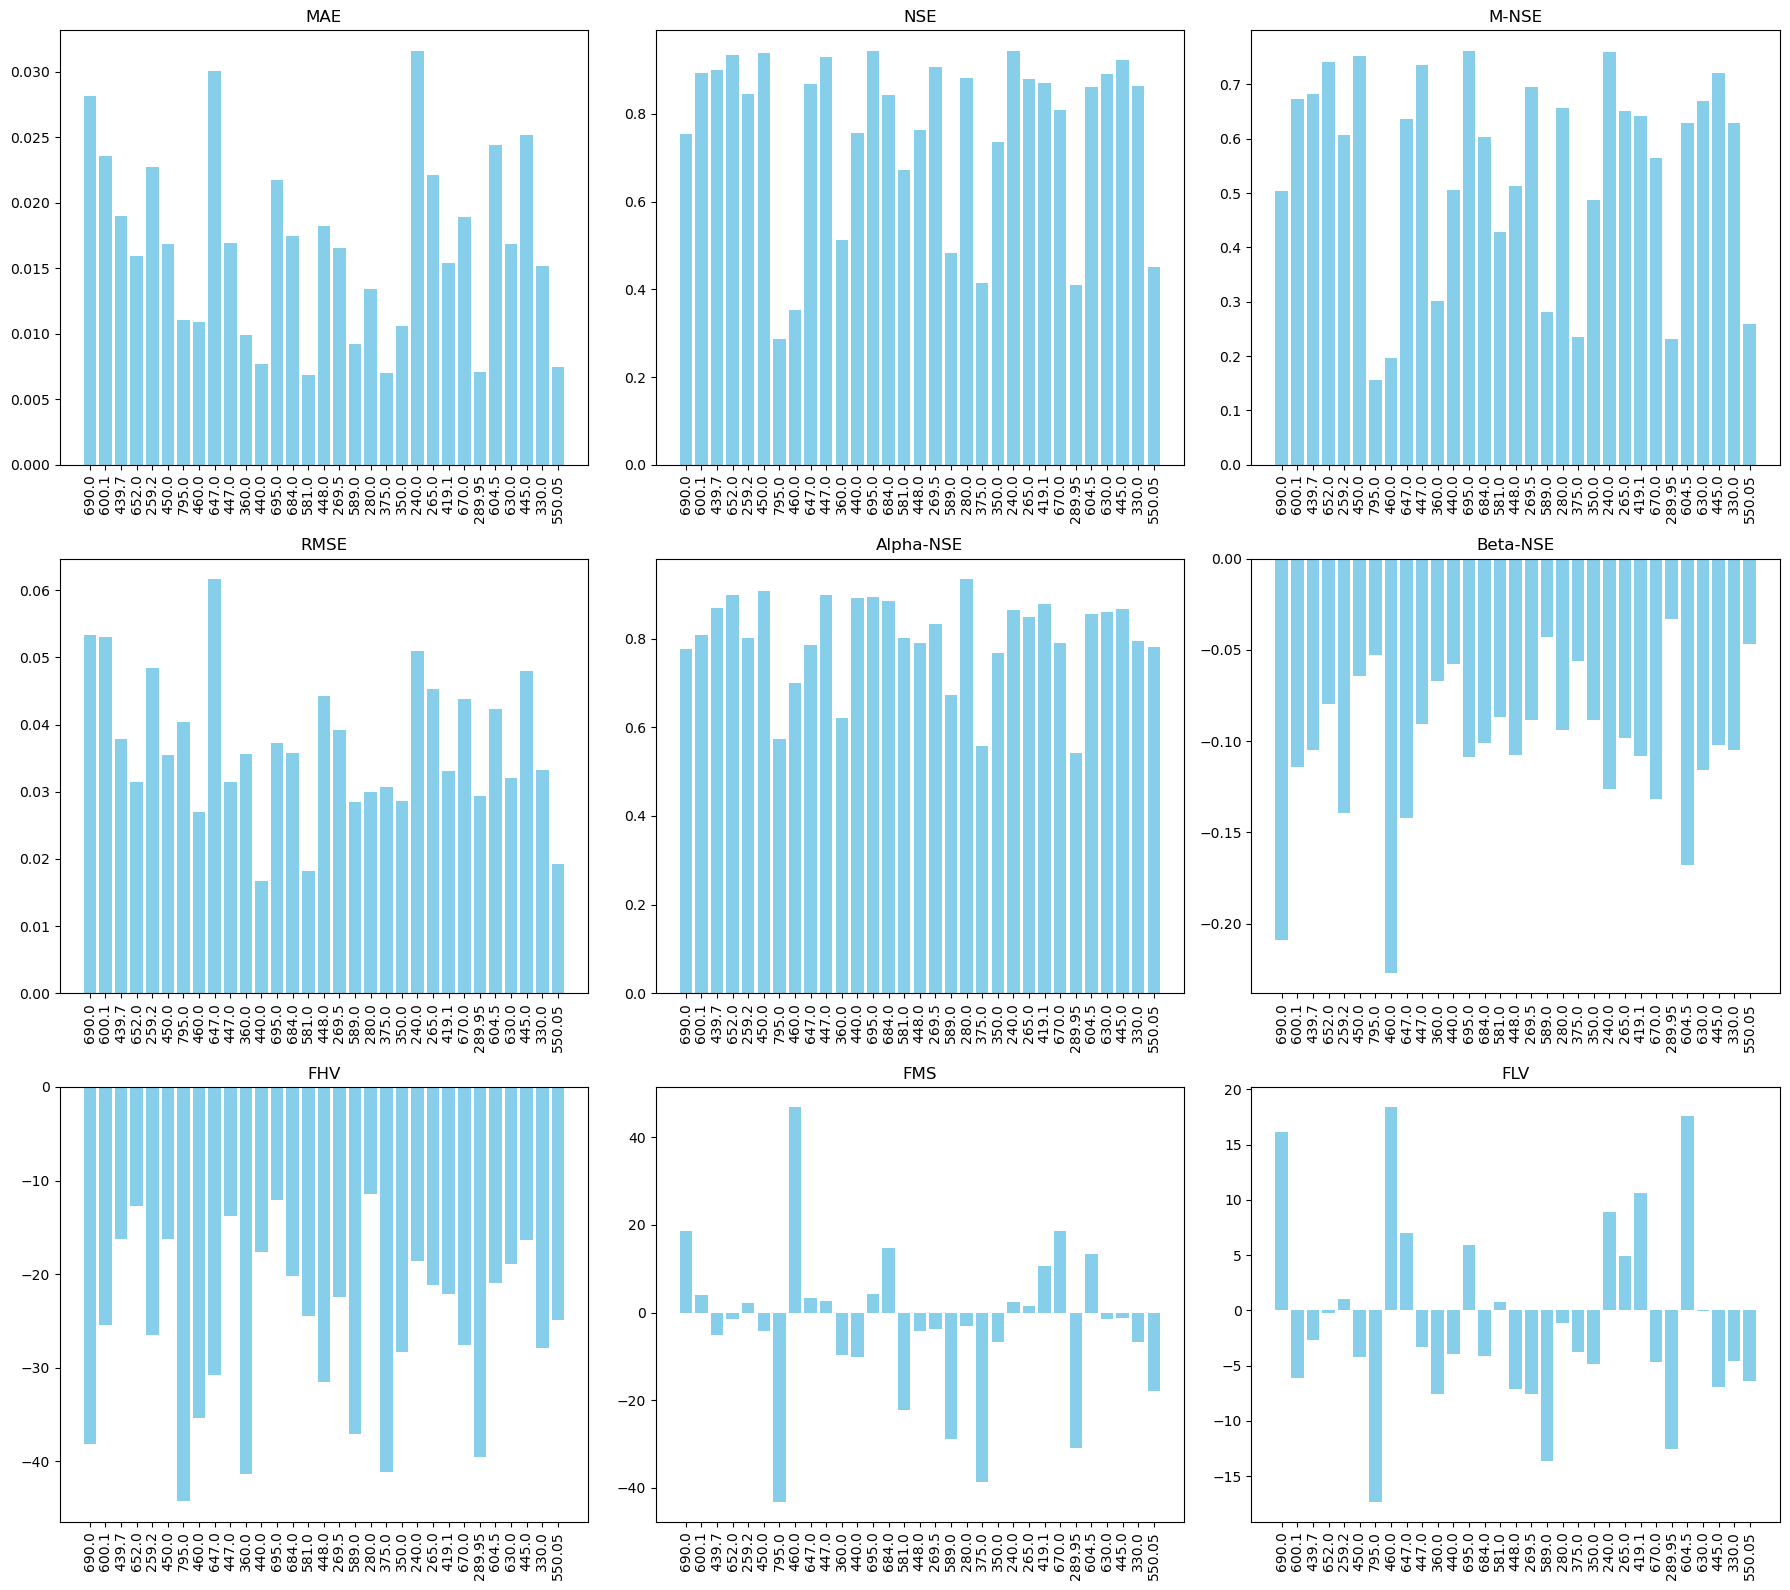

In [22]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 16))
    axes = axes.flatten()
    metric_names = ['MAE', 'NSE', 'M-NSE', 'RMSE', 'Alpha-NSE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

    station_ids = list(metrics.keys())  # Get the list of station IDs to use as labels

    for i, metric in enumerate(metric_names):
        values = [metrics[station_id][metric] for station_id in metrics]
        x_ticks = range(len(station_ids))  # Create a list of tick positions
        axes[i].bar(x_ticks, values, color='skyblue')
        axes[i].set_title(metric)
        axes[i].set_xticks(x_ticks)  # Set the tick positions on the x-axis
        axes[i].set_xticklabels(station_ids, rotation=90)  # Set the tick labels, now that the ticks are fixed

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


## Lets descale the data to get sclaed metrices

In [23]:
def load_scalers(output_path):
    scalers = {}
    files = [f for f in os.listdir(output_path) if f.endswith('_scaler.pkl')]
    for file in files:
        station_id = file.split('_')[1]  # Assuming file name format 'station_{ID}_scaler.pkl'
        with open(os.path.join(output_path, file), 'rb') as f:
            scalers[station_id] = pickle.load(f)
    return scalers

scalers = load_scalers('/home/agupt344/Final project/processed_data')


In [24]:
def predict_and_descale_data(model, test_data, scalers):
    predictions = {}
    for station_id, (X_test, y_test) in test_data.items():
        X_tensor = torch.tensor(X_test).float()
        pred = model(X_tensor).detach().numpy().squeeze()

        actual = y_test.squeeze()

        # Reshape predictions for descaling
        if pred.ndim == 1:
            pred = pred.reshape(-1, 1)
        if actual.ndim == 1:
            actual = actual.reshape(-1, 1)

        # Descale predictions and actual data using only the first feature column of the scaler
        pred_descaled = scalers[station_id].inverse_transform(pred)[:, 0]  # Adjust as needed
        actual_descaled = scalers[station_id].inverse_transform(actual)[:, 0]  # Adjust as needed

        predictions[station_id] = (pred_descaled, actual_descaled)
    return predictions


In [25]:
def predict_and_descale_data(model, test_data, scalers):
    predictions = {}
    for station_id, (X_test, y_test) in test_data.items():
        X_tensor = torch.tensor(X_test).float().to(device)
        pred = model(X_tensor).detach().cpu().numpy().squeeze()
        actual = y_test.squeeze()

        # Ensure data is 2D (single feature data should be reshaped)
        pred = pred.reshape(-1, 1) if pred.ndim == 1 else pred
        actual = actual.reshape(-1, 1) if actual.ndim == 1 else actual

        # Determine the number of features the scaler was trained with
        num_features = scalers[station_id].scale_.shape[0]

        # Add dummy columns to match the scaler's expected number of features
        pred_padded = np.hstack([pred, np.zeros((pred.shape[0], num_features - 1))])
        actual_padded = np.hstack([actual, np.zeros((actual.shape[0], num_features - 1))])

        # Descale using the full feature set
        pred_descaled = scalers[station_id].inverse_transform(pred_padded)[:, 0]  # Extract only the relevant column
        actual_descaled = scalers[station_id].inverse_transform(actual_padded)[:, 0]

        predictions[station_id] = (pred_descaled, actual_descaled)

    return predictions


In [26]:
predictions = predict_and_descale_data(transformer_model, test_data, scalers)


In [27]:
metrics = calculate_metrics(predictions)

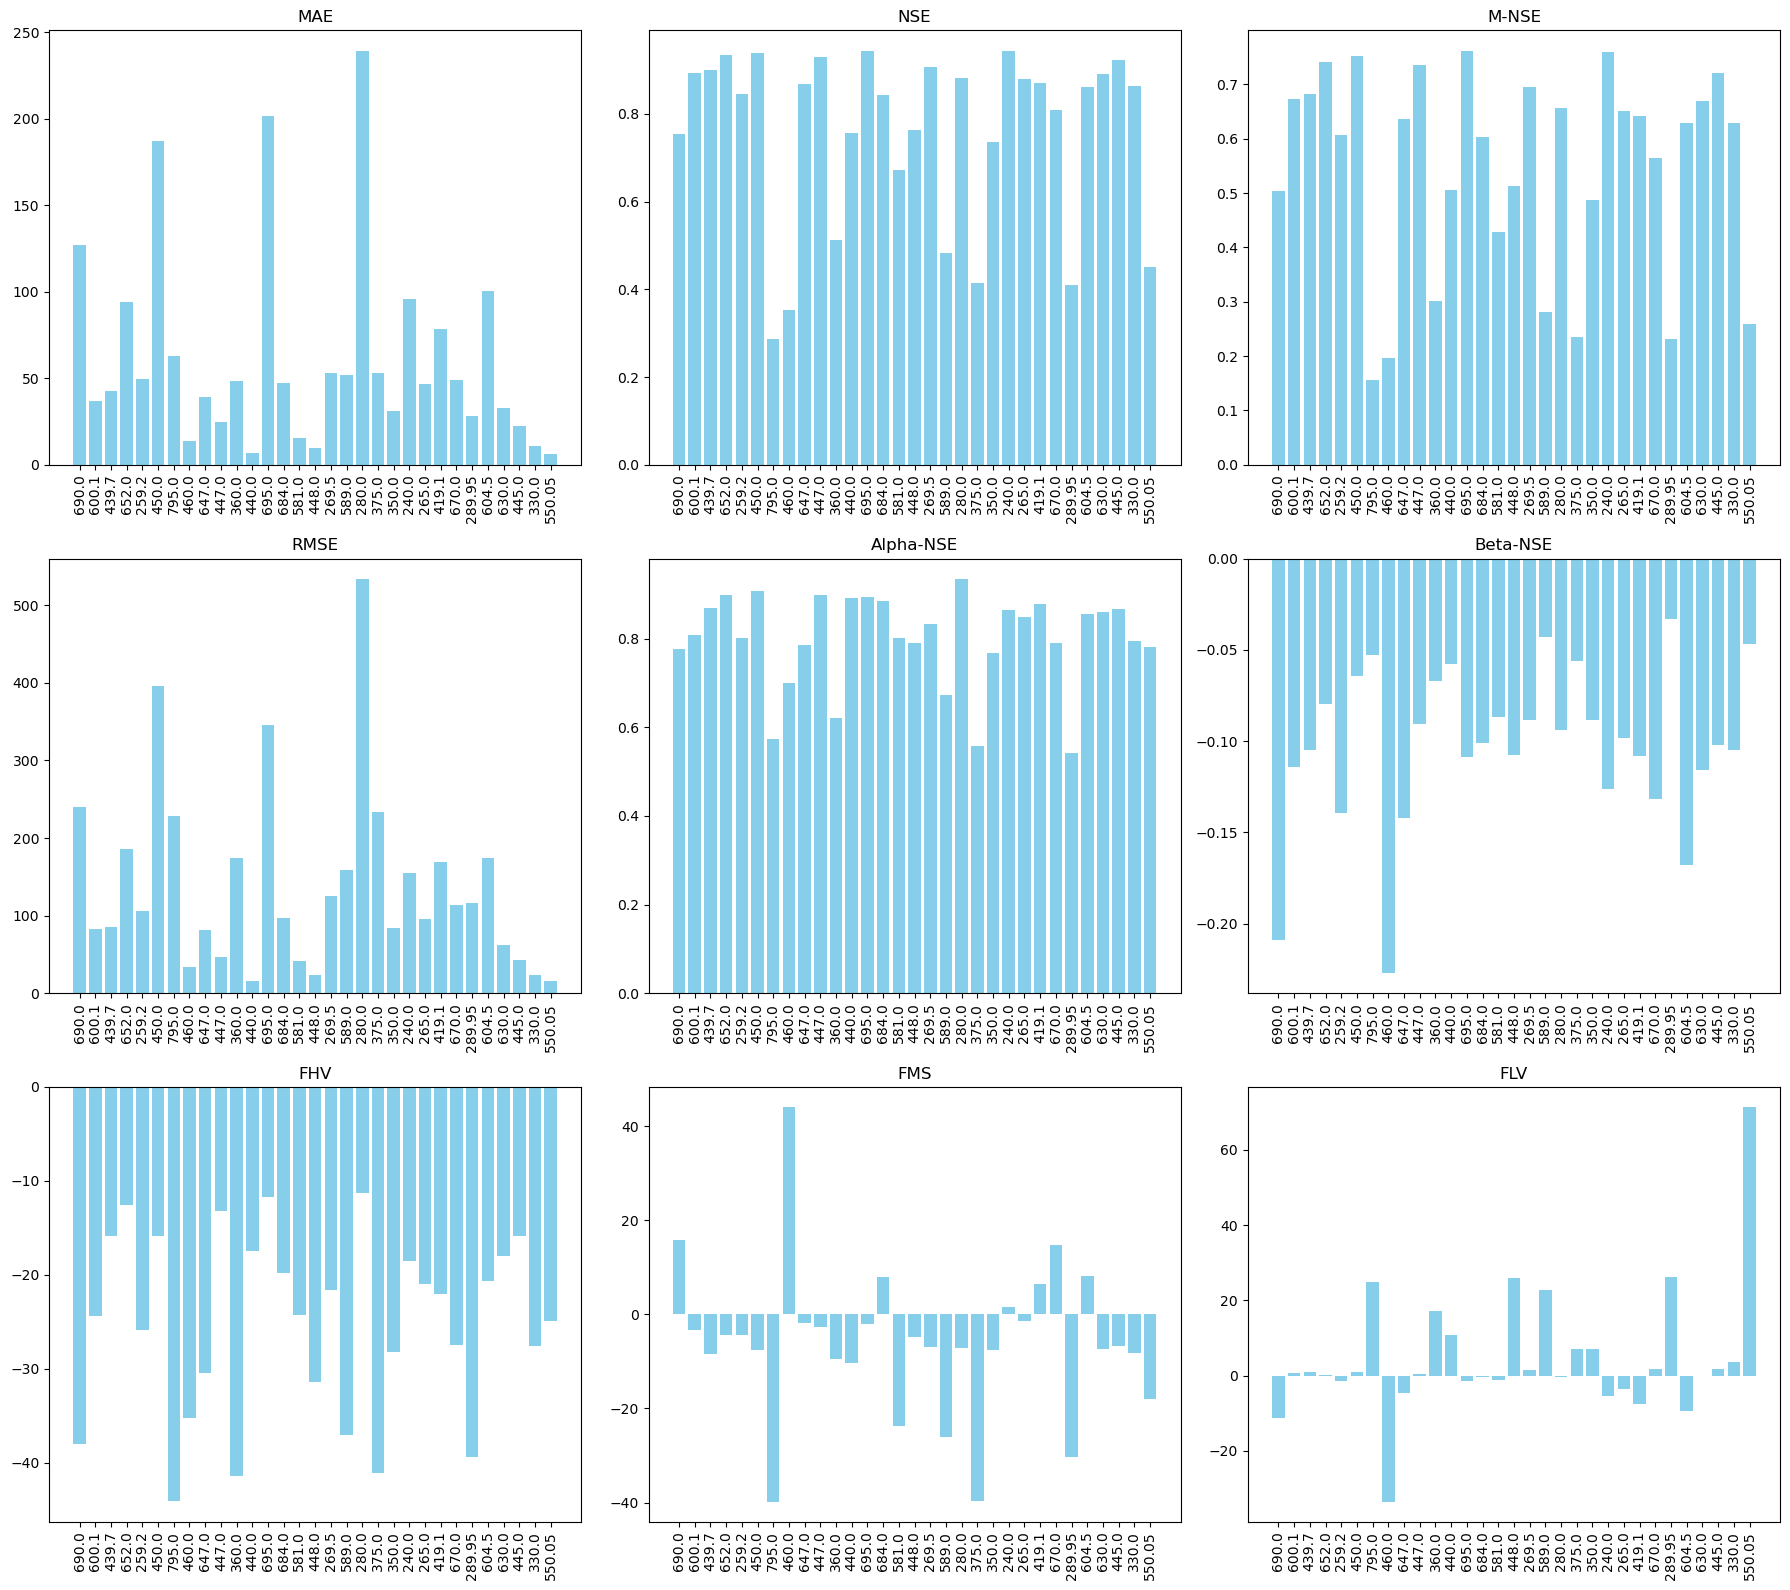

In [28]:
plot_metrics(metrics)

## Lets visualize the results

In [29]:
def load_and_descale_data(file_path, scaler):
    with open(file_path, 'rb') as f:
        X_train, y_train = pickle.load(f)  # Assuming data is saved as (X_train, y_train)

    y_train = np.array(y_train)  # Convert list or other formats to NumPy array if necessary
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)  # Ensure it's 2D for consistency with scaler expectations

    # Add dummy columns to match the number of features the scaler was trained with
    num_features = scaler.scale_.shape[0]
    if y_train.shape[1] < num_features:
        # Create a dummy array with zeros for additional features
        dummy_features = np.zeros((y_train.shape[0], num_features - 1))
        y_train_padded = np.hstack([y_train, dummy_features])
    else:
        y_train_padded = y_train

    data_descaled = scaler.inverse_transform(y_train_padded)[:, 0]  # Descale and extract only the first column
    return data_descaled


In [30]:
# Dictionary to store descaled training data
training_data_descaled = {}
for station_id in scalers.keys():
    training_file_path = f'/home/agupt344/Final project/processed_data/station_{station_id}_train.pkl'
    if os.path.exists(training_file_path):
        training_data_descaled[station_id] = load_and_descale_data(training_file_path, scalers[station_id])



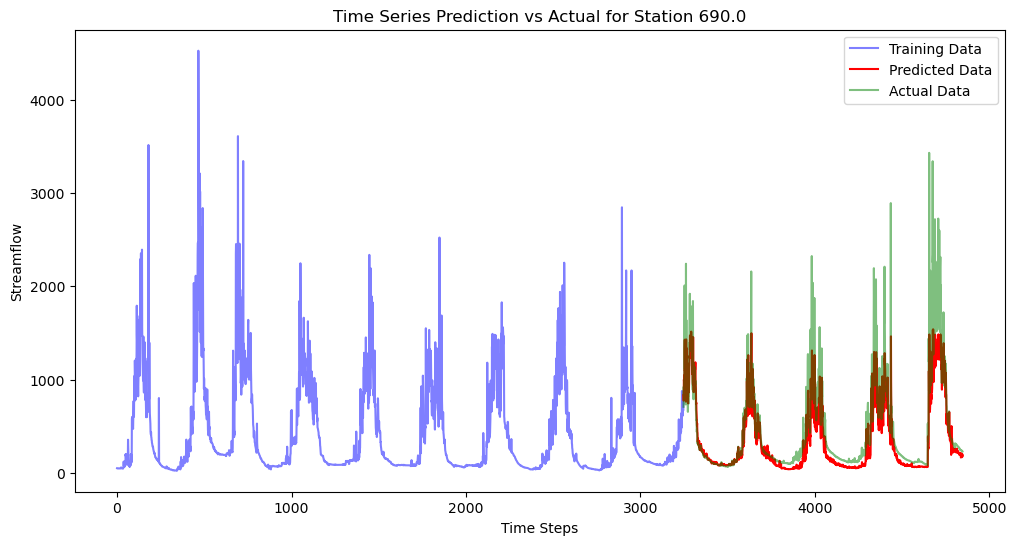

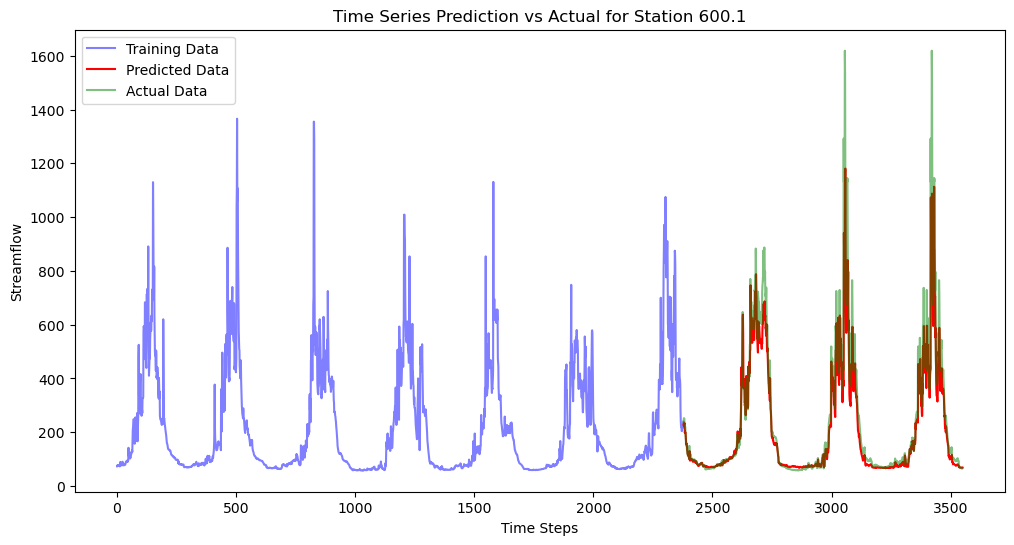

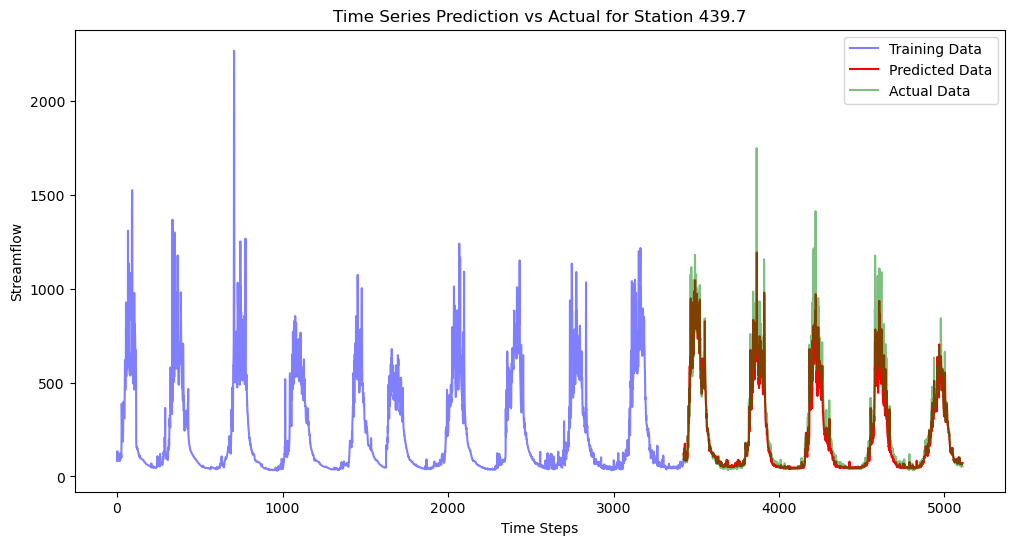

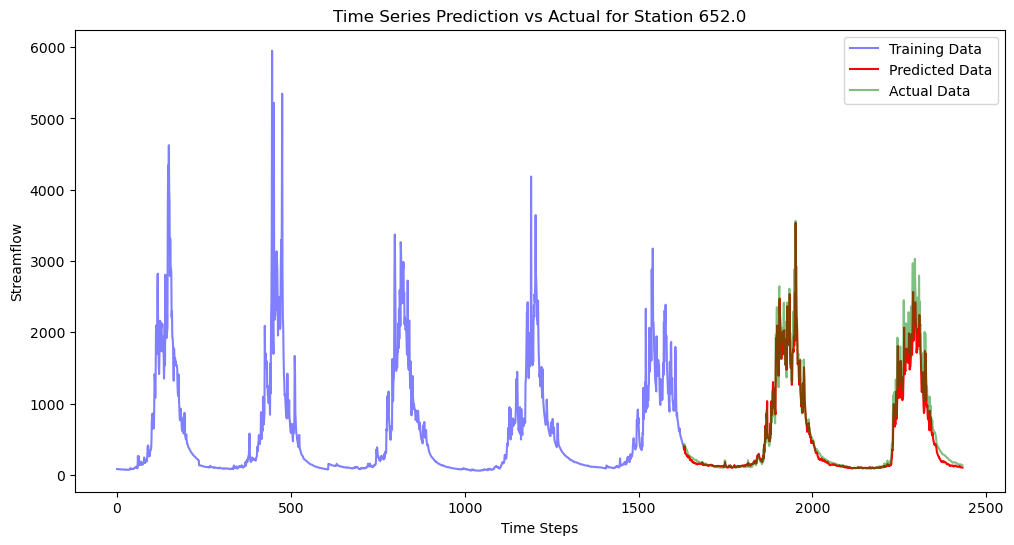

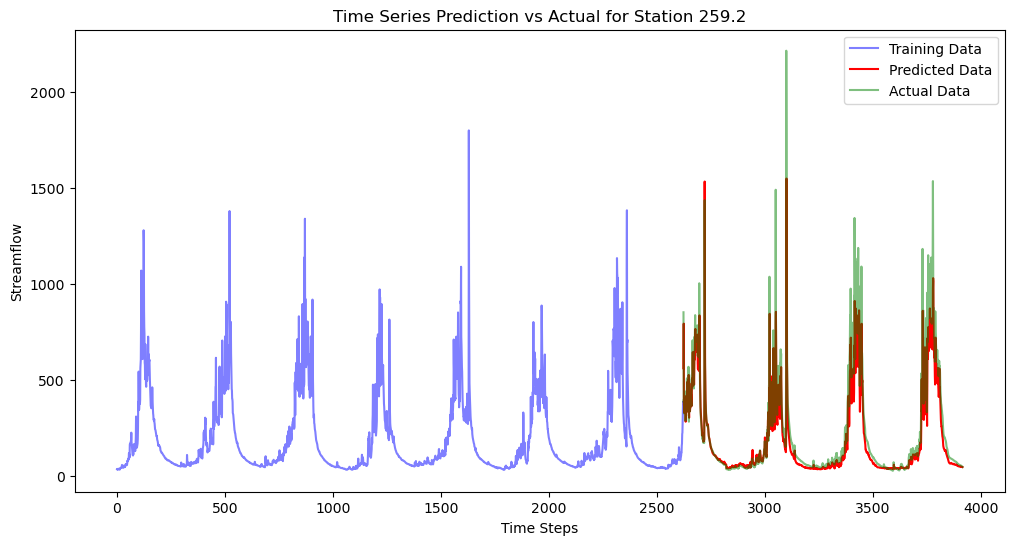

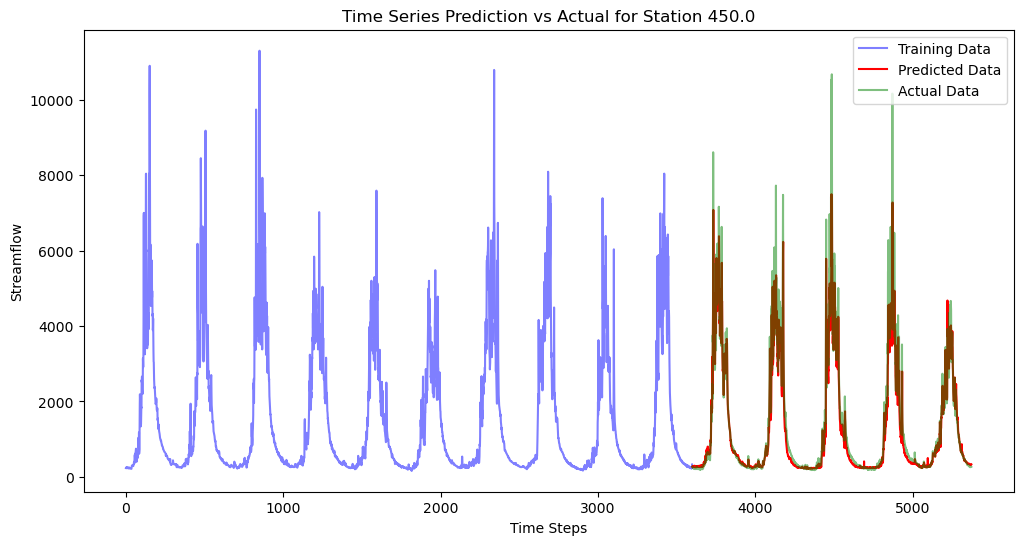

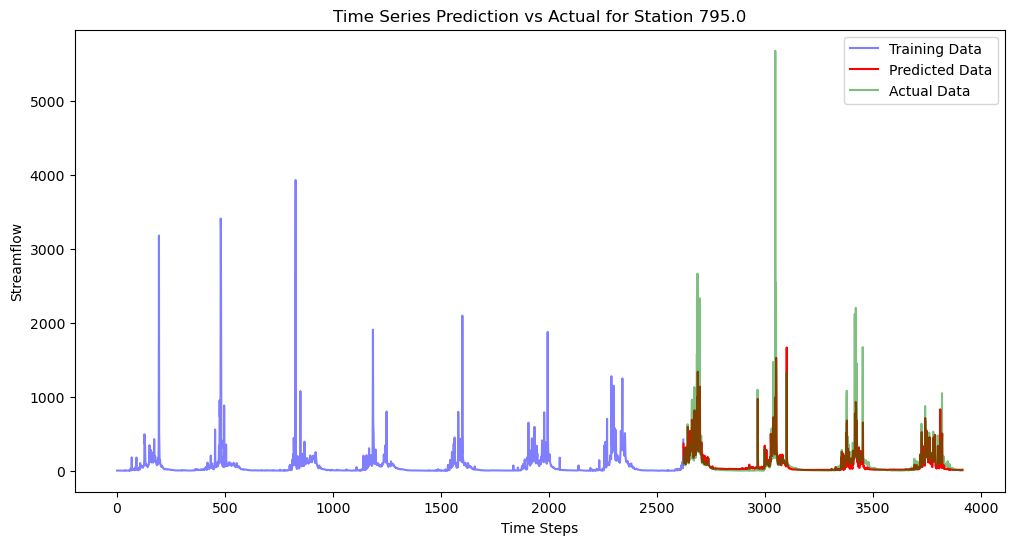

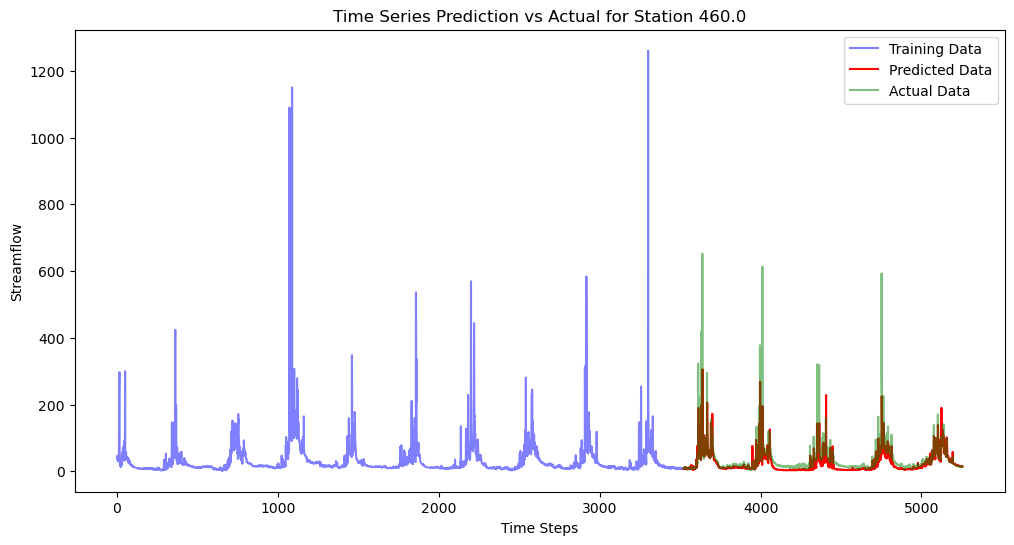

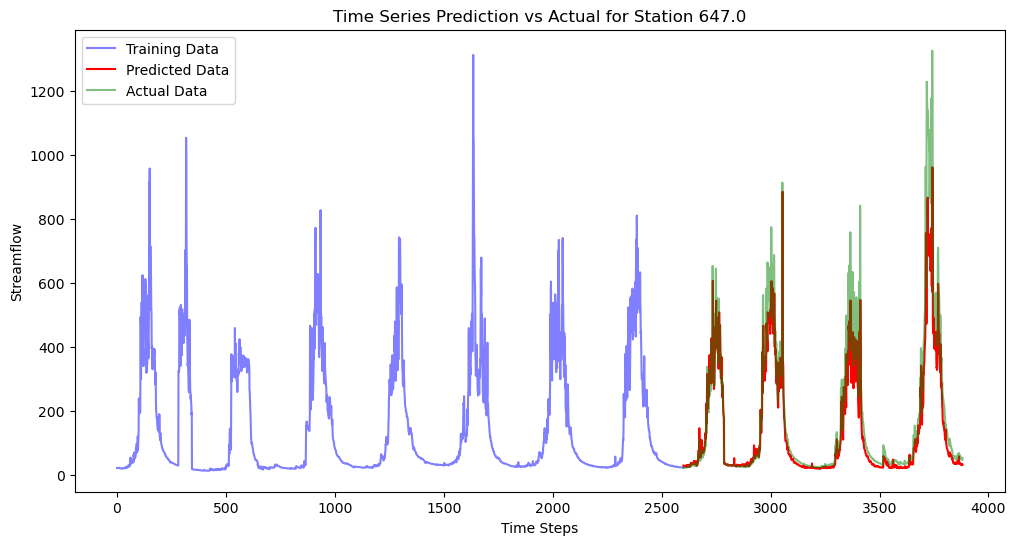

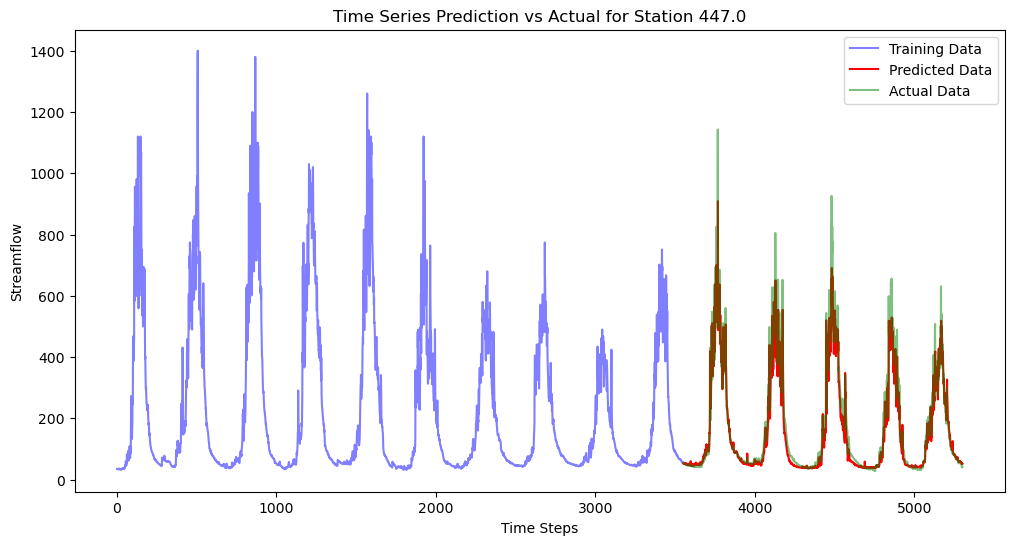

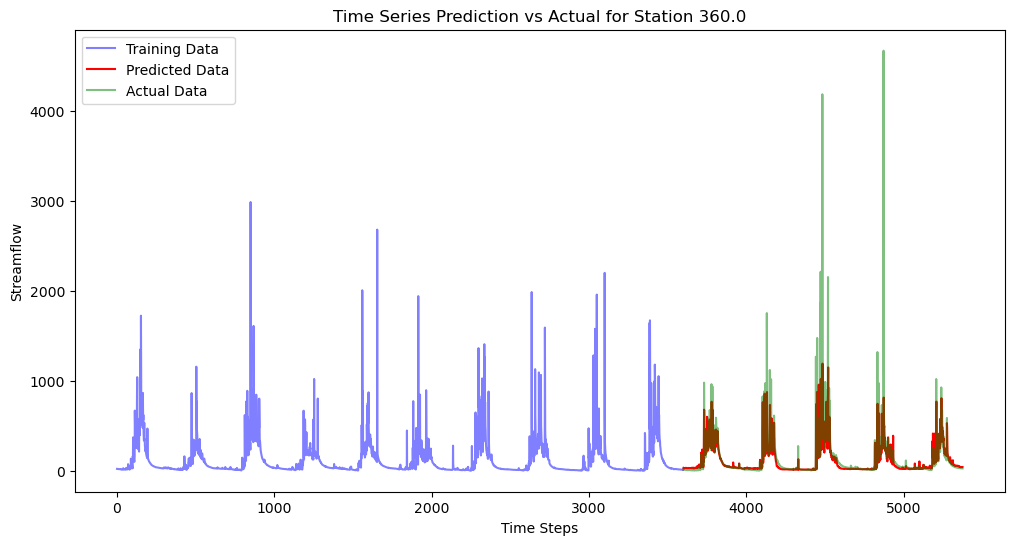

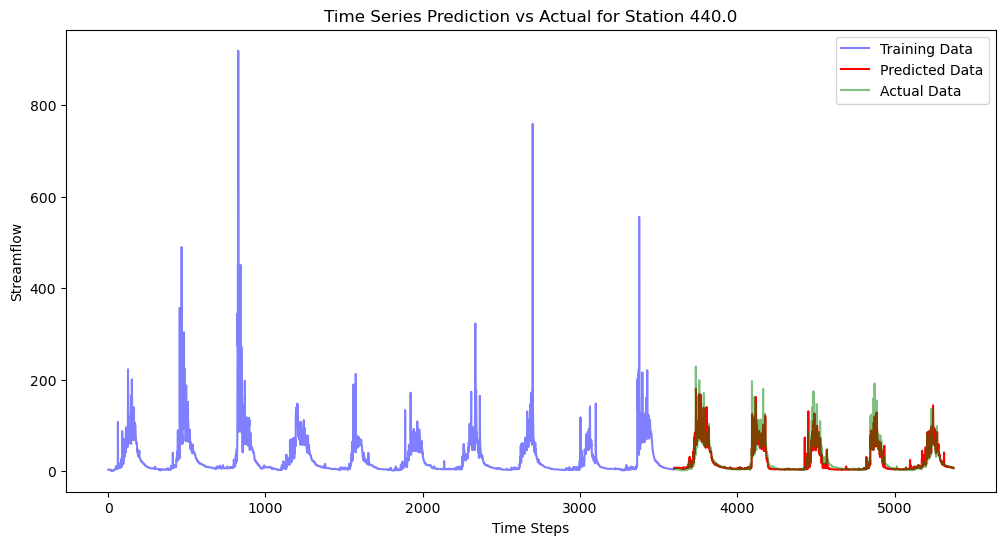

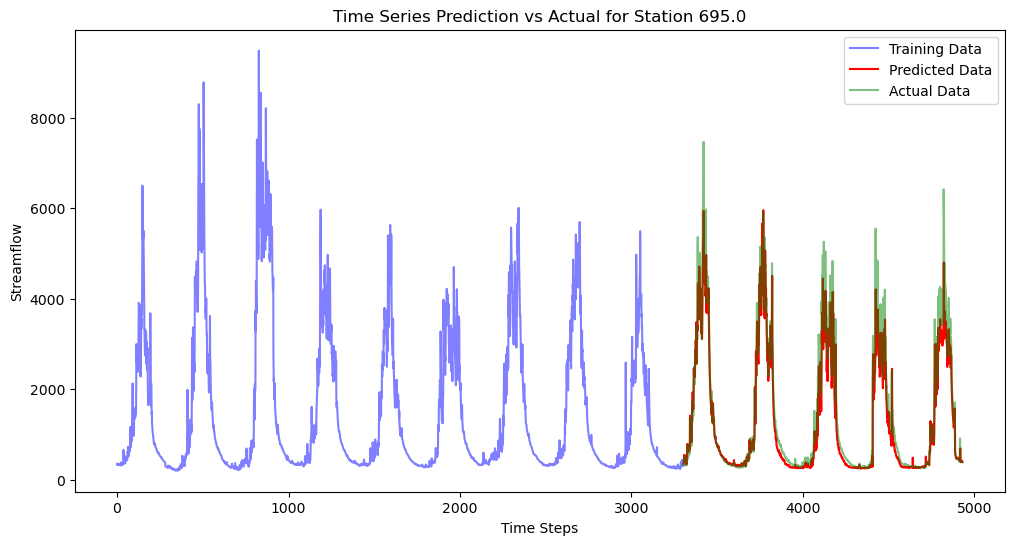

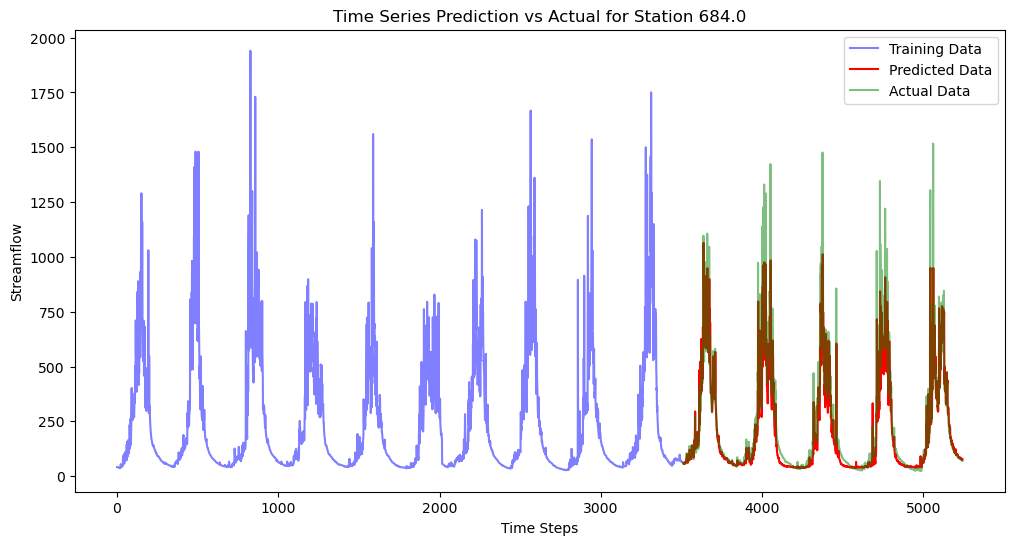

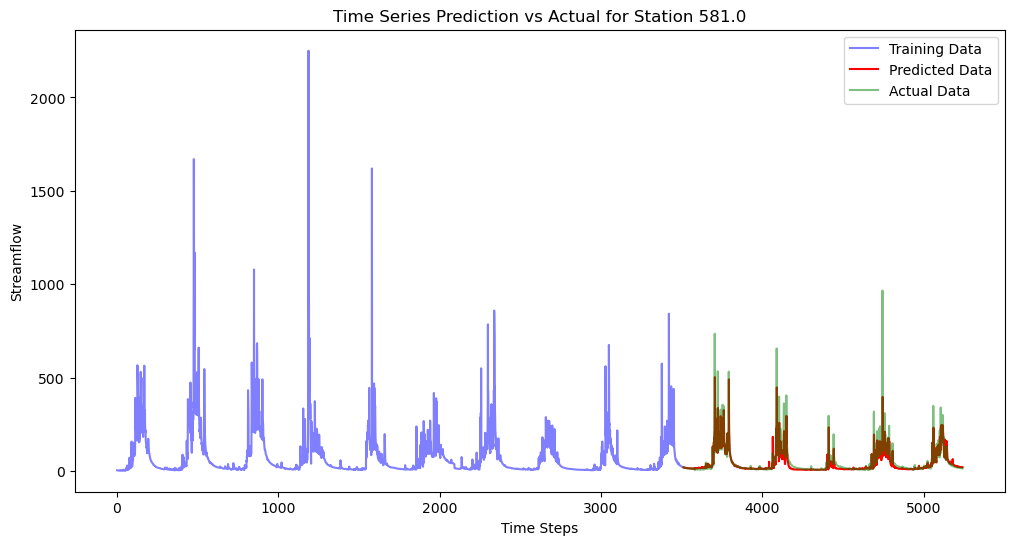

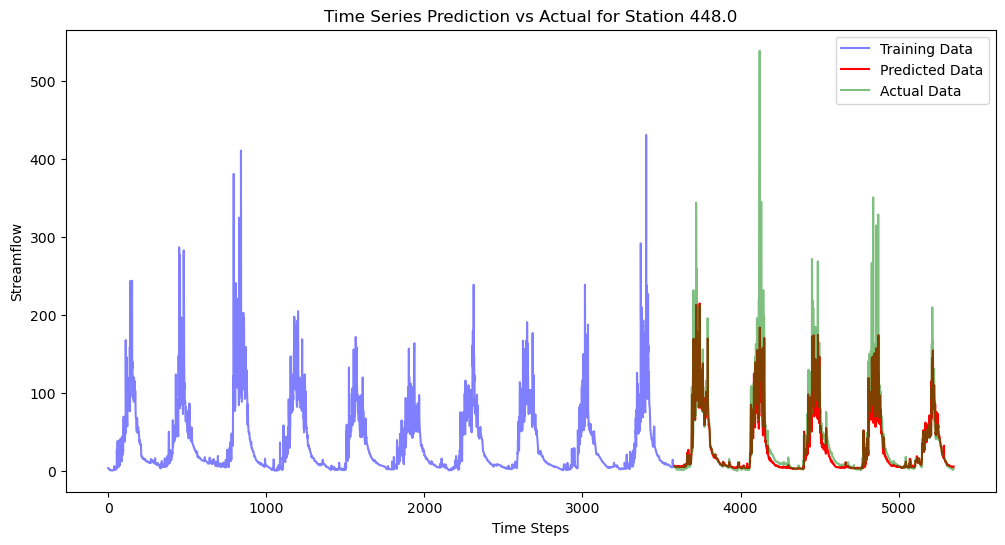

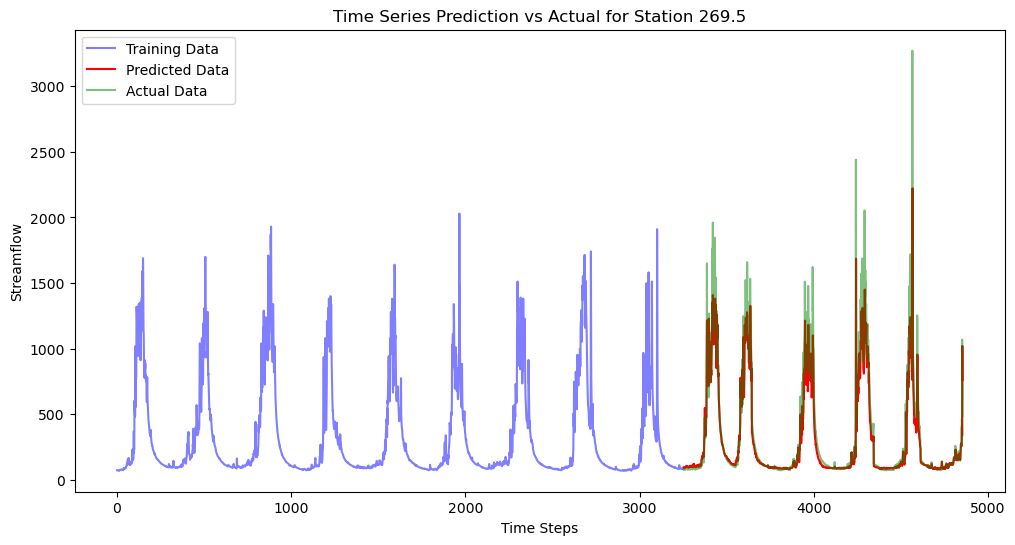

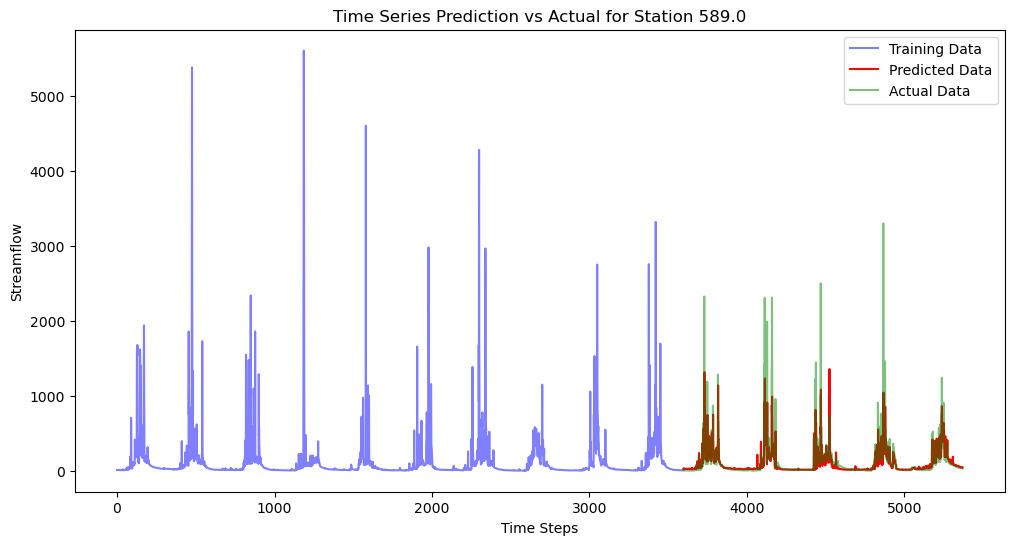

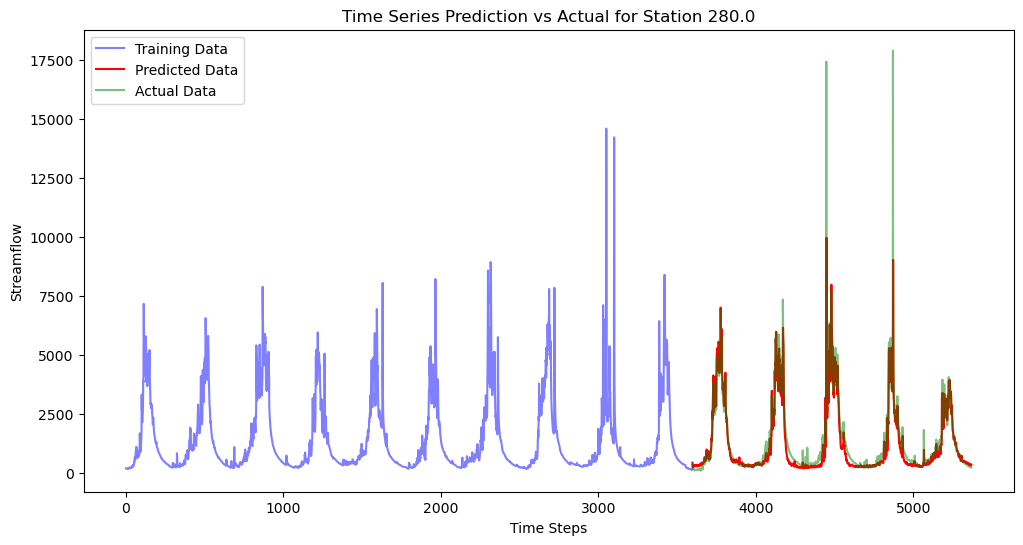

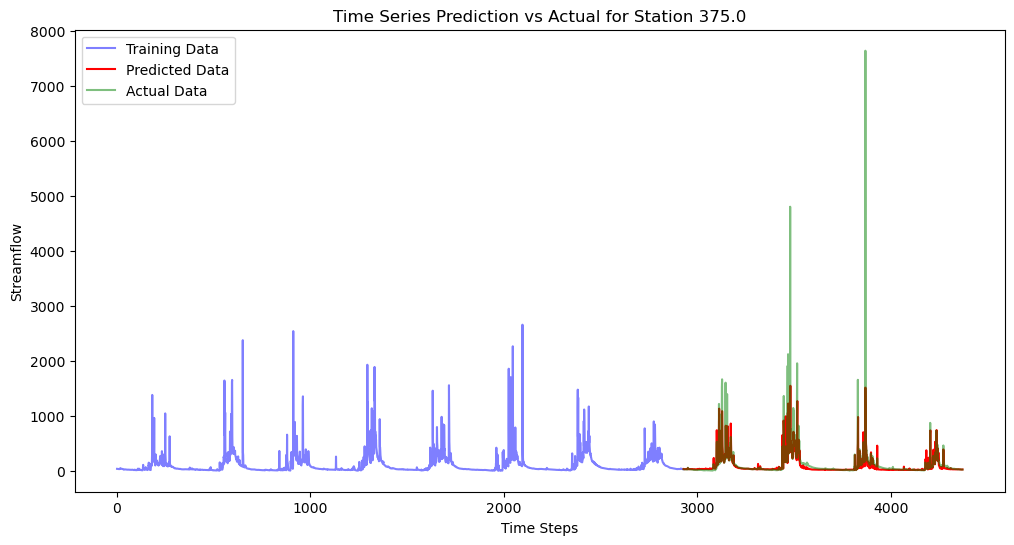

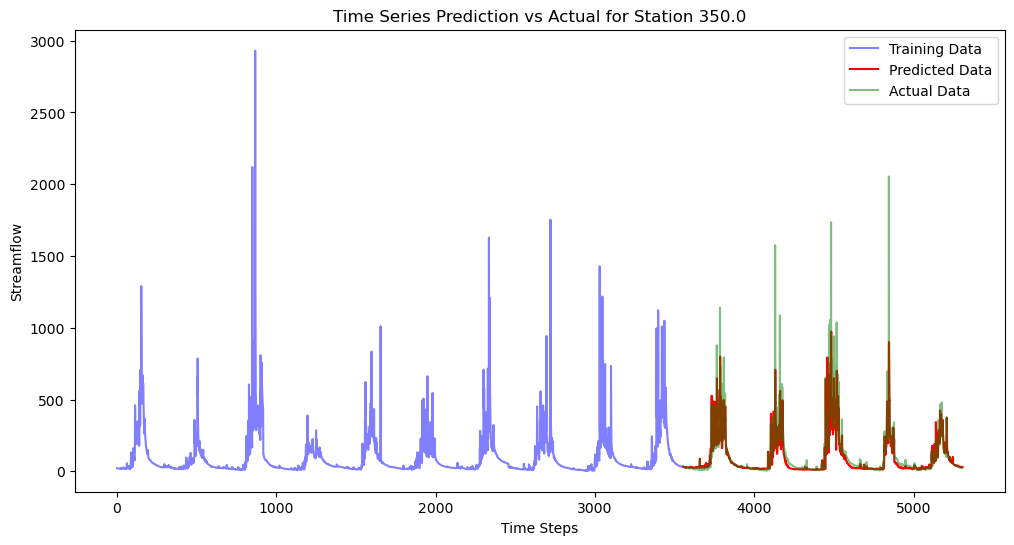

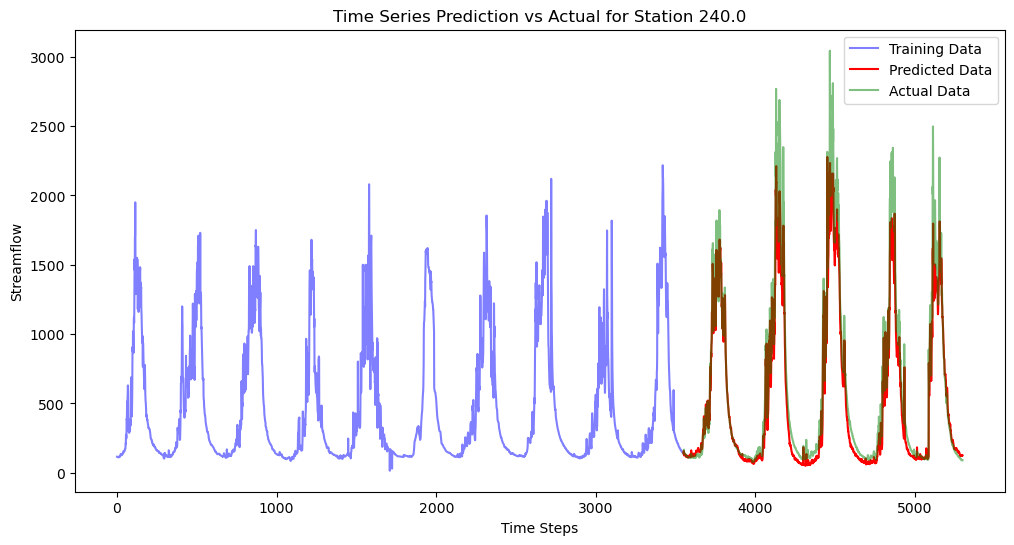

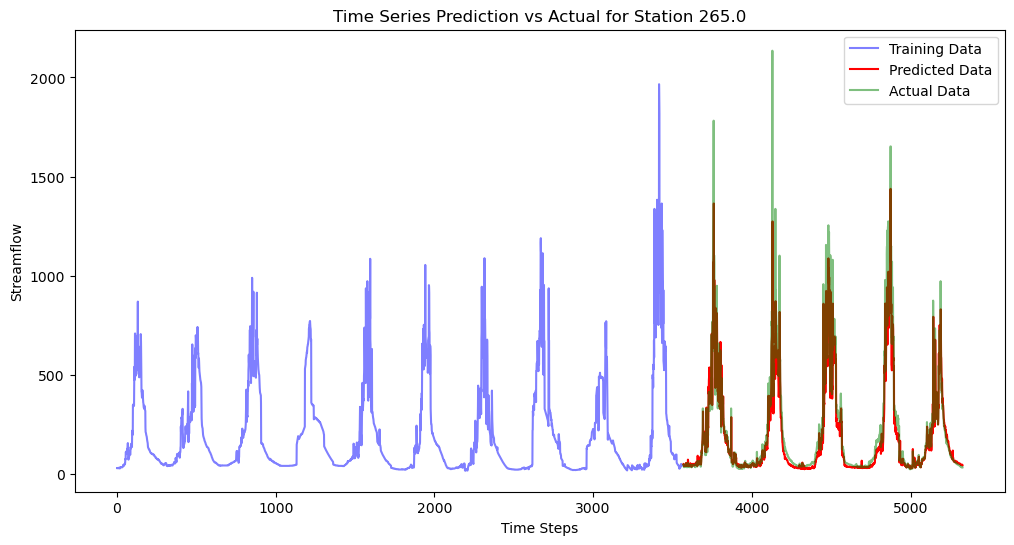

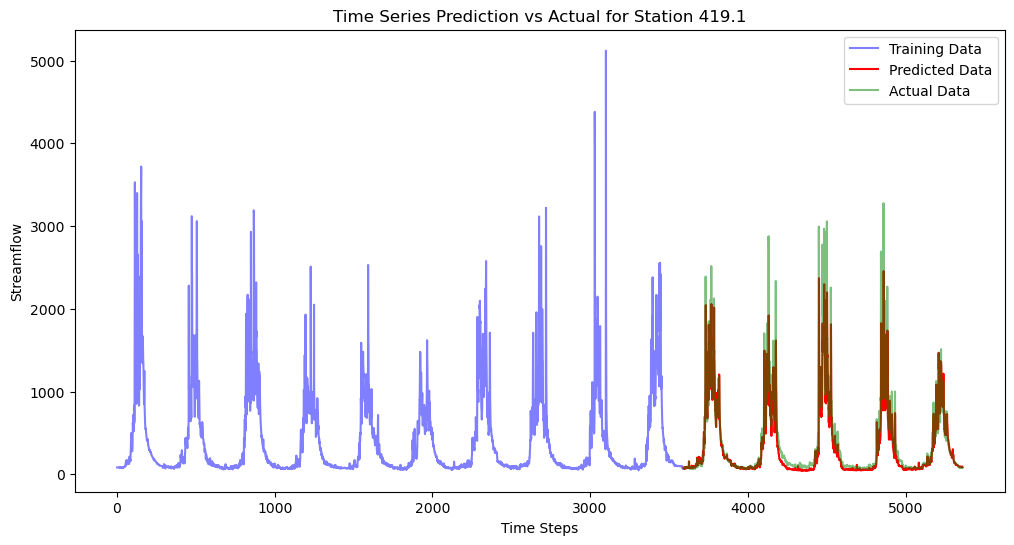

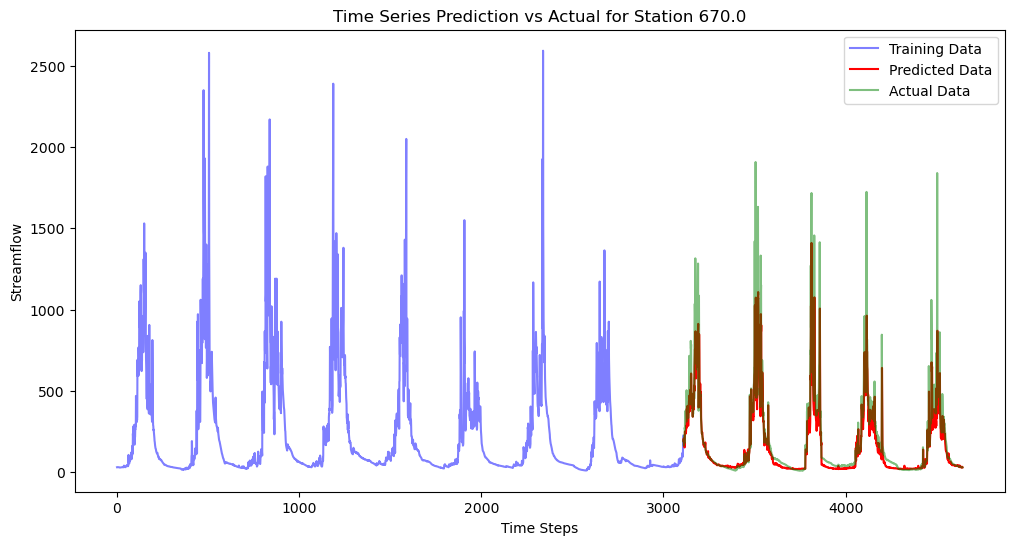

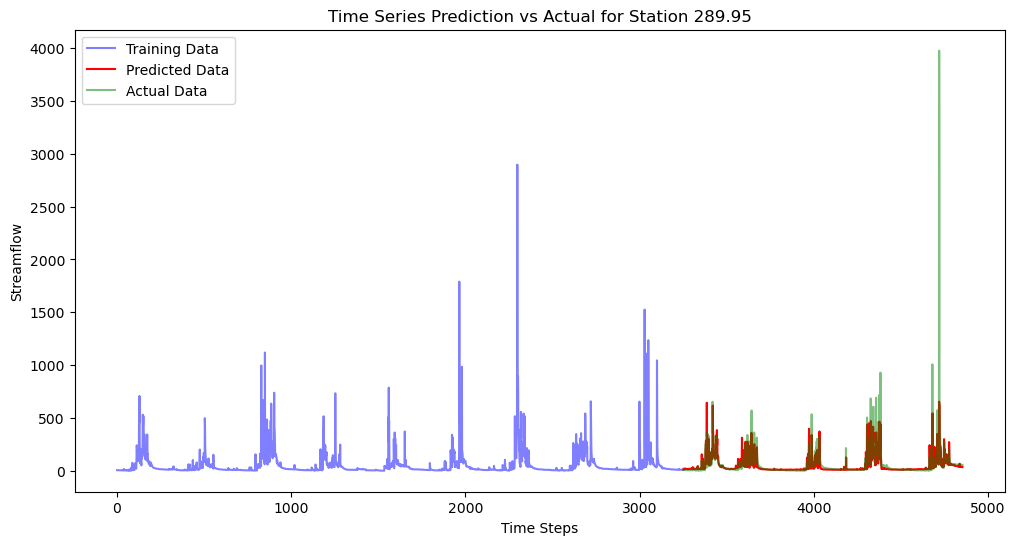

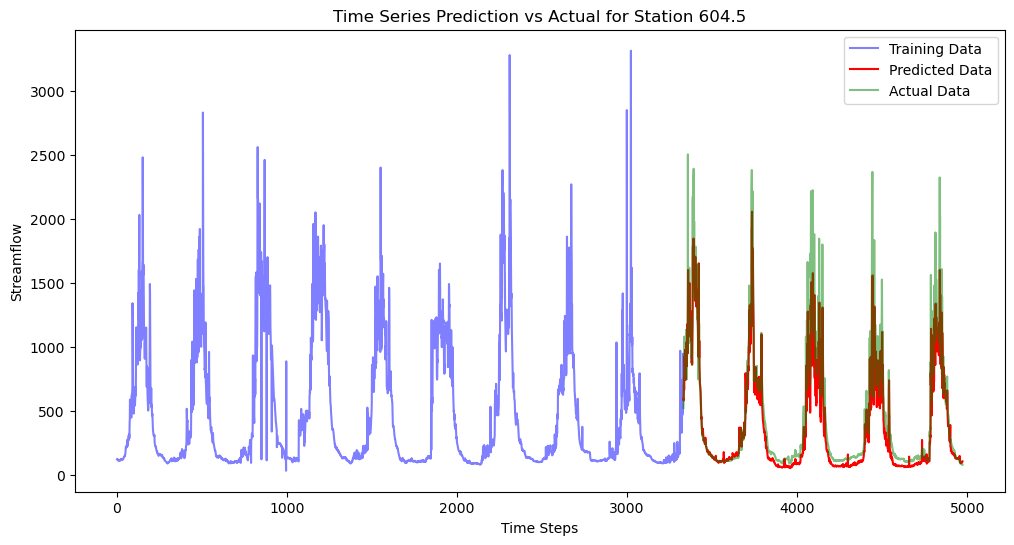

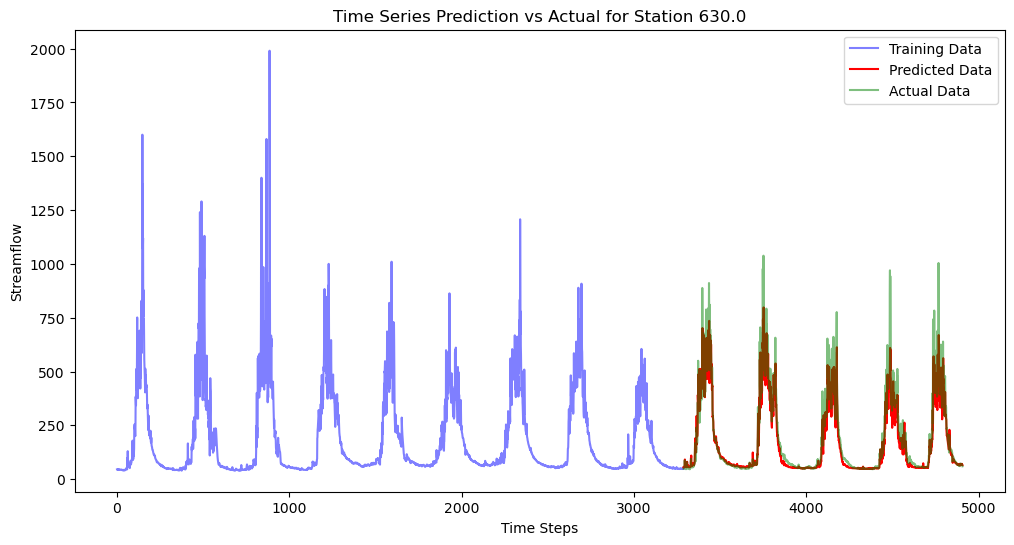

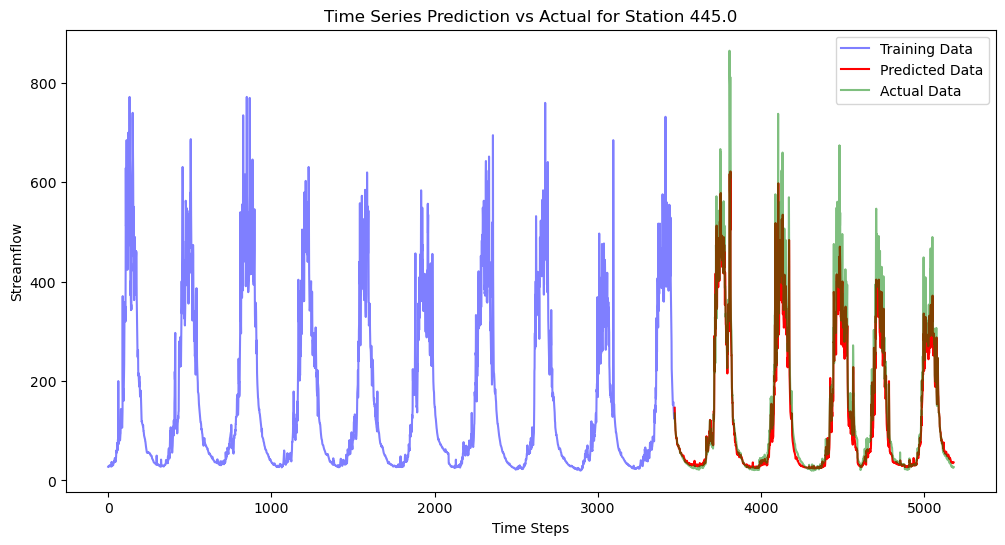

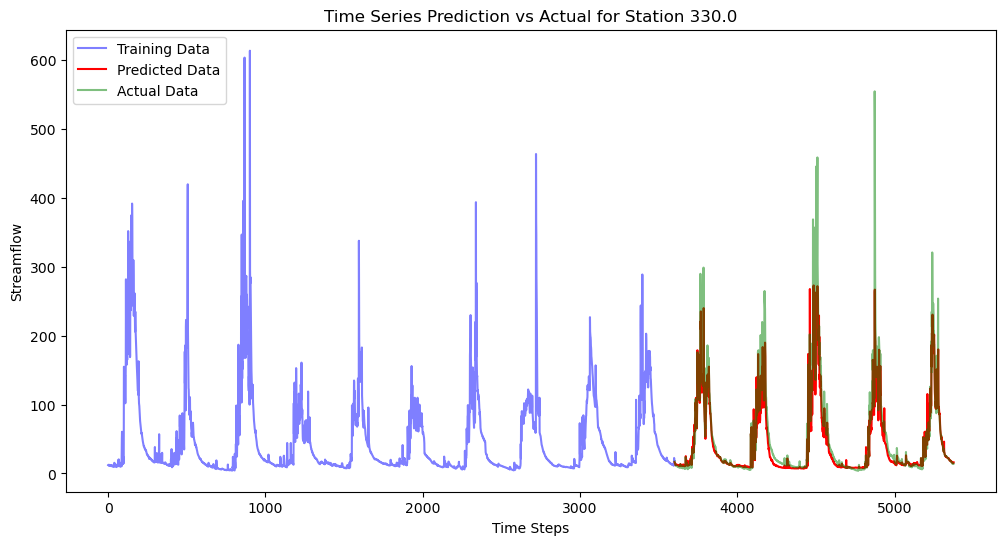

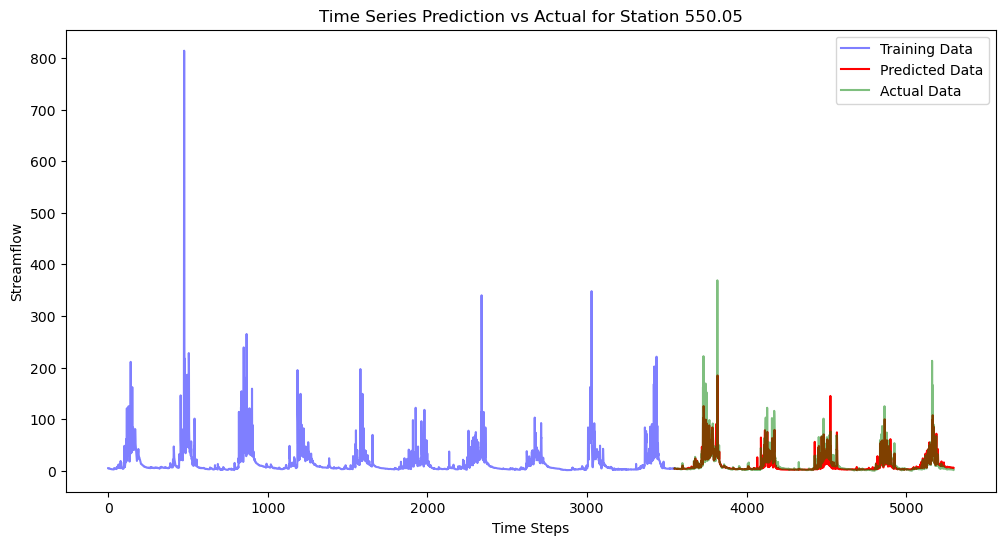

In [31]:
def plot_station_data(station_id, training_data, predictions, actual):
    plt.figure(figsize=(12, 6))
    plt.title(f"Time Series Prediction vs Actual for Station {station_id}")
    plt.plot(training_data, label='Training Data', color='blue', alpha=0.5)
    plt.plot(range(len(training_data), len(training_data) + len(predictions)), predictions, label='Predicted Data', color='red')
    plt.plot(range(len(training_data), len(training_data) + len(actual)), actual, label='Actual Data', color='green', alpha=0.5)
    plt.legend()
    plt.xlabel("Time Steps")
    plt.ylabel("Streamflow")
    plt.show()

# Assuming `predictions` dictionary is structured with each station's predicted and actual descaled data:
# predictions[station_id] = (pred_descaled, actual_descaled)
for station_id in predictions.keys():
    if station_id in training_data_descaled:
        plot_station_data(station_id, training_data_descaled[station_id], predictions[station_id][0], predictions[station_id][1])


##### plot_station_data(station_id, training_data_descaled[station_id], predictions[station_id][0], predictions[station_id][1])

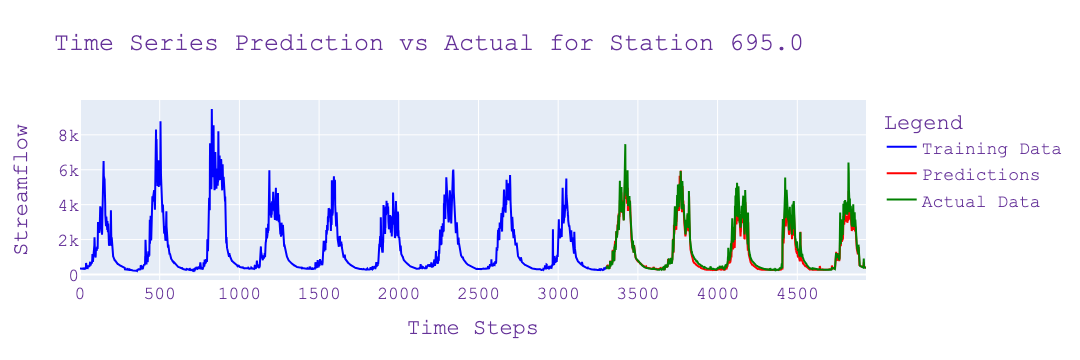

In [32]:
import plotly.graph_objects as go

def plot_station_data_interactive(station_id, training_data, predictions, actual):
    # Create time steps for the predictions and actual data
    train_len = len(training_data)
    pred_len = len(predictions)
    pred_steps = list(range(train_len, train_len + pred_len))

    # Create a Plotly graph
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=training_data, mode='lines', name='Training Data', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=pred_steps, y=predictions, mode='lines', name='Predictions', line=dict(color='red', width=2)))
    fig.add_trace(go.Scatter(x=pred_steps, y=actual, mode='lines', name='Actual Data', line=dict(color='green', width=2)))

    # Update plot layout
    fig.update_layout(
        title=f"Time Series Prediction vs Actual for Station {station_id}",
        xaxis_title='Time Steps',
        yaxis_title='Streamflow',
        legend_title="Legend",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )

    # Show the plot
    fig.show()

# Example usage
station_id = '695.0'  # Replace 'your_station_id' with the actual station ID you want to plot
if station_id in training_data_descaled:
    plot_station_data_interactive(station_id, training_data_descaled[station_id], predictions[station_id][0], predictions[station_id][1])
